In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [ ]:
#Reload Training data
# root_dir = "./mnist_testData/Training_data"
root_dir = "./MNIST_data/train"
# root_dir = "./Training_data"

train_data = []
train_target = []
valid_data = []
valid_target = []
idx = 0
for label in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label)
    for filename in os.listdir(label_path):
        img_path = os.path.join(label_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if idx %  10 == 11:
            valid_data.append(img)
            valid_target.append(label)
        else:
            train_data.append(img)
            train_target.append(label)
        idx += 1


In [ ]:
# Reload Testing data
root_dir = "./MNIST_data/test"

test_data = []
test_target = []

for label in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label)
    idx = 0
    for filename in os.listdir(label_path):
        # if idx == 100:
        #     break
        img_path = os.path.join(label_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_data.append(img)
        test_target.append(label)
        idx += 1

In [252]:
#label one hot encoding
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

In [253]:
#np reshape
train_data = np.array(train_data)
train_target = np.array(train_target)
train_target = one_hot_encode(train_target.astype(int))

train_data = train_data.reshape(train_data.shape[0], -1)
train_target = train_target.reshape(train_target.shape[0], -1)
train_data = train_data / 255

# valid_data = np.array(valid_data)
# valid_target = np.array(valid_target)

# valid_data = valid_data.reshape(valid_data.shape[0], -1)
# valid_target = valid_target.reshape(valid_target.shape[0], -1)
# valid_data = valid_data / 255

test_data = np.array(test_data)
test_target = np.array(test_target)

test_data = test_data.reshape(test_data.shape[0], -1)
test_target = test_target.reshape(test_target.shape[0], -1)
test_data = test_data / 255

In [254]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def derivative(x):
    return np.multiply(x, 1 - x)

In [255]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Randomly initialize weights
        self.weights_hidden = np.random.randn(input_size, hidden_size) * 0.1
        self.weights_output = np.random.randn(hidden_size, output_size) * 0.1
        # self.weights_hidden = np.random.rand(input_size, hidden_size) * 0.1
        # self.weights_output = np.random.rand(hidden_size, output_size) * 0.1
        self.delta_weights_hidden_sum = np.zeros((input_size, hidden_size))
        self.delta_weights_output_sum = np.zeros((hidden_size, output_size))

    def feedforward(self, X):
        # First layer
        self.s1 = np.matmul(X, self.weights_hidden)
        self.a1 = sigmoid(self.s1)

        # Second layer
        self.s2 = np.matmul(self.a1, self.weights_output)
        self.output = sigmoid(self.s2)
        return self.output

    def backpropagation(self, X, y, learning_rate):
        y = y.astype(float)
        # Error in output
        output_error = y - self.output
        output_delta = output_error * derivative(self.output)

        # Error in hidden layer
        hidden_error = np.matmul(output_delta ,self.weights_output.T)
        hidden_delta = hidden_error * derivative(self.a1)

        self.a1 = self.a1.reshape(self.a1.shape[0], -1)
        X = X.reshape(X.shape[0], -1)
        output_delta = output_delta.reshape(output_delta.shape[0], -1)
        hidden_delta = hidden_delta.reshape(hidden_delta.shape[0], -1)

        # Gradient descent update
        self.delta_weights_output_sum += learning_rate * np.matmul(self.a1, output_delta.T)
        self.delta_weights_hidden_sum += learning_rate * np.matmul(X, hidden_delta.T)
    
    def update_weights(self, batch_size):
        self.weights_hidden += self.delta_weights_hidden_sum / batch_size
        self.weights_output += self.delta_weights_output_sum / batch_size
        self.delta_weights_hidden_sum = np.zeros(self.delta_weights_hidden_sum.shape)
        self.delta_weights_output_sum = np.zeros(self.delta_weights_output_sum.shape)

In [256]:
#hyperparameters
epochs = 100
learning_rate = 1
input_size = 784
hidden_size = 128
output_size = 10
batch_size = 100

In [257]:
#Train
nn = NeuralNetwork(input_size, hidden_size, output_size)
lr = learning_rate
best_acc = 0
accuracy = []

for epoch in range(epochs):
    # Shuffle both train_data and train_target using the same permutation
    indices = np.random.permutation(train_data.shape[0])
    train_data_shuffle = train_data[indices]
    train_target_shuffle = train_target[indices]
    
    train_acc = 0
    for idx, img in enumerate(train_data_shuffle):
        y = train_target_shuffle[idx]
        # Feedforward
        o = nn.feedforward(img)

        # Backpropagation
        nn.backpropagation(img, y, lr)
        
        # Update weights
        if (idx + 1) % batch_size == 0:
            nn.update_weights(batch_size)

        if np.argmax(o) == np.argmax(y):
            train_acc += 1
    #learning rate scheduling
    lr = learning_rate * (1 + (epoch + 1) / epochs)
    # lr = lr * 0.99
    accuracy.append(train_acc / len(train_data))
    print(f"Epoch {epoch+1}, Correct: {train_acc} / {len(train_data)} , Training Accuracy: {train_acc / len(train_data) * 100:.2f}%")
    valid_acc = 0
    # for idx, img in enumerate(valid_data):
    #     y = valid_target[idx][0].astype(int)
    #     # Feedforward
    #     o = nn.feedforward(img)

    #     if np.argmax(o) == y:
    #         valid_acc += 1
    # print(f"Correct: {valid_acc} / {len(valid_data)} , Validation Accuracy: {valid_acc / len(valid_data) * 100:.2f}%")
    if valid_acc > best_acc:
        best_acc = train_acc
        np.save("weights_hidden.npy", nn.weights_hidden)
        np.save("weights_output.npy", nn.weights_output)
        print("Weights saved")


Epoch 1, Correct: 47550 / 60000 , Training Accuracy: 79.25%
Weights saved
Epoch 2, Correct: 53905 / 60000 , Training Accuracy: 89.84%
Weights saved
Epoch 3, Correct: 54669 / 60000 , Training Accuracy: 91.11%
Weights saved
Epoch 4, Correct: 55173 / 60000 , Training Accuracy: 91.95%
Weights saved
Epoch 5, Correct: 55557 / 60000 , Training Accuracy: 92.59%
Weights saved
Epoch 6, Correct: 55905 / 60000 , Training Accuracy: 93.17%
Weights saved
Epoch 7, Correct: 56127 / 60000 , Training Accuracy: 93.55%
Weights saved
Epoch 8, Correct: 56382 / 60000 , Training Accuracy: 93.97%
Weights saved
Epoch 9, Correct: 56573 / 60000 , Training Accuracy: 94.29%
Weights saved
Epoch 10, Correct: 56804 / 60000 , Training Accuracy: 94.67%
Weights saved
Epoch 11, Correct: 57009 / 60000 , Training Accuracy: 95.02%
Weights saved
Epoch 12, Correct: 57169 / 60000 , Training Accuracy: 95.28%
Weights saved
Epoch 13, Correct: 57283 / 60000 , Training Accuracy: 95.47%
Weights saved
Epoch 14, Correct: 57409 / 60000 ,

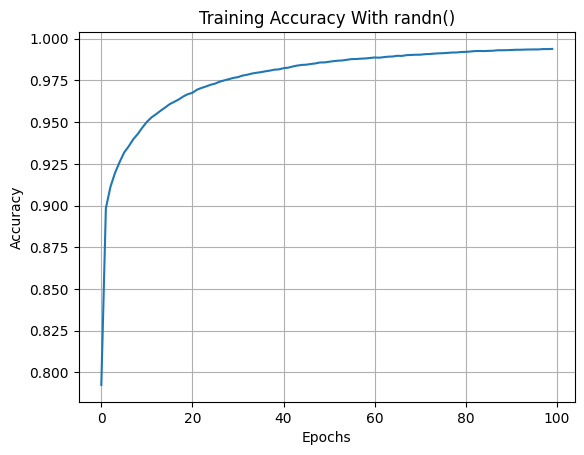

In [261]:
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy With randn()')
plt.grid(True)
plt.show()

In [ ]:
# Test
result_path = "./output.txt"
root_dir = "./Testing_data1"
# Reload weights record
nn.weights_hidden = np.load("weights_hidden.npy")
nn.weights_output = np.load("weights_output.npy")

acc = 0

# answer = [1, 0, 1, 2, 3, 4, 0, 2, 1, 2, 3, 4, 0, 4, 1, 2, 3, 4, 0, 4, 1, 2, 3, 4, 0]
# answer = np.array(answer)

with open(result_path, 'w+') as f:
    for filename in os.listdir(root_dir):
        img_path = os.path.join(root_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = np.array(img)
        img = img / 255
        img = img.reshape(-1)
        o = nn.feedforward(img)
        # if np.argmax(o) == answer[int(filename.split(".")[0])]:
        #     acc += 1
        # print(f'{filename} {np.argmax(o)} {answer[int(filename.split(".")[0])]}')

        txt_name = filename.split('.')[0]
        f.write("{} {}\n".format(txt_name, np.argmax(o)))

# print(f"Correct: {acc} / {len(answer)} , Accuracy: {acc / len(answer) * 100:.2f}%")




In [260]:
#Test
acc = 0
nn.weights_hidden = np.load("weights_hidden.npy")
nn.weights_output = np.load("weights_output.npy")
for idx, img in enumerate(test_data):
    y = test_target[idx][0].astype(int)
    # Feedforward
    o = nn.feedforward(img)

    if np.argmax(o) == y:
        acc += 1
    
print(f"Correct: {acc} / {len(test_data)} , Accuracy: {acc / len(test_data) * 100:.2f}%")

Correct: 9799 / 10000 , Accuracy: 97.99%
